## What is a State in LangGraph?

- **State = shared memory** that moves through your LangGraph workflow.
- It holds everything the nodes need to see or update (like a conversation or tool results).

### What’s inside a state?
- Typically a Python dictionary with fields like:
  - `messages`: the conversation history
  - `tool_results`: outputs from tools
  - `query`: user input
  - Anything else your app needs to remember

In [8]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

## What are Nodes and Edges in LangGraph?

### Nodes
- **Nodes are the steps in your flow.**
- Each node does something: calls an LLM, looks up a database, filters results, etc.
- You can think of a node like a function or block in a flowchart.
- Example: A node might answer a question using an LLM.

### Edges
- **Edges connect the nodes and decide what happens next.**
- They define the **path** the data takes.
- Edges can be simple (go to the next step) or conditional (go here **if** something is true).
- Example: If the LLM says “I need more info,” the edge might loop back to a retriever node.

### Think of it like this:
- Nodes = **What to do**
- Edges = **Where to go next**

### Why it matters in LangGraph
- LangGraph lets you build **smart workflows** where LLMs can make decisions.
- You use nodes to define actions.
- You use edges to define logic (e.g., "if answer is good, stop", "if not, try again").

### Bonus analogy:
> It's like a choose-your-own-adventure book:
> - Each page is a **node** (an event or action),
> - The choices are **edges** (which page you flip to next).


In [9]:
import os
from langchain.chat_models import init_chat_model

OPENAI_API_KEY: str | None = os.getenv("OPENAI_API_KEY")

#os.environ["OPENAI_API_KEY"] = "sk-..."

llm = init_chat_model("openai:gpt-4.1")

In [10]:
def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

In [11]:
graph = graph_builder.compile()

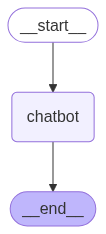

In [12]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [13]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  hi


Assistant: Hello! How can I help you today? 😊
User: What do you know about LangGraph?


KeyboardInterrupt: 

### Add a tool

In [14]:
TAVILY_API_KEY: str | None = os.getenv("TAVILY_API_KEY")

In [15]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki',
   'url': 'https://deepwiki.com/langchain-ai/langgraph-101/2.2-nodes-and-edges',
   'content': 'Nodes and Edges | langchain-ai/langgraph-101 | DeepWiki Nodes and Edges Nodes and Edges What are Nodes and Edges? In LangGraph, a graph is composed of nodes connected by edges to form a directed workflow. Nodes are the workhorses of LangGraph - they are Python functions that receive the current graph state as input, perform operations, and return updates to that state. Edges define the flow of execution between nodes in a LangGraph. graph_builder.add_edge("retrieve_documents", "generate_response") Conditional edges use a function to determine the next node based on the current state. Building a Graph with Nodes and Edges graph_builder.add_node("retrieve_documents", retrieve_documents) graph_builder.add_edge(

In [16]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

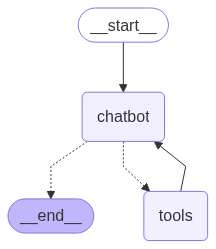

In [17]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [ ]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break
        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User:  hi


Assistant: Hello! How can I help you today?


User:  what do you know about nodes and edges of langgraph?


Assistant: **LangGraph** is a framework designed to make it easier to build applications with complex, graph-based workflows, particularly for language models such as those from OpenAI or other LLM providers. It’s often used for orchestrating multi-step, branching, and looping workflows involving LLMs, tools, and code.

Here’s what “nodes” and “edges” mean in the context of LangGraph:

---

### **Nodes**
- **Definition:** Nodes are the core units of computation or processing in a LangGraph graph. Each node represents a specific step or operation, such as calling an LLM, running a custom function, querying a database, or invoking a tool.
- **Types:** Nodes can handle various tasks:
  - Executing language model prompts/chains.
  - Wrapping custom Python functions.
  - Integrating with APIs or external tools.
- **Inputs & Outputs:** Each node takes input (possibly from previous nodes), executes logic, and produces output, which then informs the graph’s flow.
- **Custom Logic:** You can de

User:  search about those nodes and edges on the internet 


Assistant: Could you please clarify what you mean by "those nodes and edges"? Are you referring to a specific context such as:

- Graph theory (mathematics/computer science)
- Nodes and edges in a neural network
- Internet/topology networks
- Blockchain/cryptography
- Another specific domain or diagram

If you can provide a bit more detail or context, I can search for the most relevant information for you!
